Cell 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
# Set a random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Cell 2: Load the Prepared Data

In [4]:
# Load the dataset, specifying the first column (index 0) as the index
data_df = pd.read_csv('features_with_regimes.csv', index_col=0, parse_dates=True)

# Drop the extra 'Price' column if it exists, as it's not a feature for the experts
if 'Price' in data_df.columns:
    data_df = data_df.drop(columns=['Price'])

print("Data loaded successfully:")
print(data_df.head())

Data loaded successfully:
             Returns  Volatility  Momentum  Intraday_Range  Regime  \
Price                                                                
2000-02-02 -0.000114    0.257009 -0.386300        0.012149       2   
2000-02-03  0.011185    0.220892  0.217114        0.019130       1   
2000-02-04 -0.000421    0.220900  0.189016        0.010728       1   
2000-02-07 -0.000091    0.220917  0.176459        0.009703       1   
2000-02-08  0.012198    0.204466  0.002081        0.012201       1   

                  gamma_0        gamma_1   gamma_2  
Price                                               
2000-02-02   0.000000e+00  6.155901e-217  1.000000  
2000-02-03  8.900589e-130   9.322043e-01  0.067796  
2000-02-04   8.998875e-10   9.973227e-01  0.002677  
2000-02-07   8.699119e-10   9.998731e-01  0.000127  
2000-02-08   3.298051e-09   9.999875e-01  0.000013  


Cell 3: Prepare Features, Target, and Gating Signals


The goal is to predict the next day's return. Therefore, our target variable y will be the 'Returns' column, shifted by one day into the past.

In [5]:
# Define the features (X), the gating signals (gammas), and the target (y)
feature_cols = ['Returns', 'Volatility', 'Momentum', 'Intraday_Range']
gamma_cols = ['gamma_0', 'gamma_1', 'gamma_2']

X = data_df[feature_cols]

# The target is the next day's return, so we shift the 'Returns' column
y = data_df['Returns'].shift(-1)

gammas = data_df[gamma_cols]

# Drop the last row since it will have a NaN value for the target 'y'
X = X.iloc[:-1]
y = y.iloc[:-1]
gammas = gammas.iloc[:-1]

print(f"Shapes after preparing target: X={X.shape}, y={y.shape}, gammas={gammas.shape}")

Shapes after preparing target: X=(6440, 4), y=(6440,), gammas=(6440, 3)


Cell 4: Scale Data and Split into Training/Test Sets

In [6]:
# Split the data into training (80%) and testing (20%) sets
# For time-series data, it's crucial NOT to shuffle the data before splitting.
X_train, X_test, y_train, y_test, gammas_train, gammas_test = train_test_split(
    X, y, gammas, test_size=0.2, shuffle=False
)

# Scale the features based on the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train_scaled.shape[0]}")
print(f"Test set size: {X_test_scaled.shape[0]}")

Training set size: 5152
Test set size: 1288


Cell 5: Create PyTorch DataLoaders

In [7]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
gammas_train_tensor = torch.tensor(gammas_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
gammas_test_tensor = torch.tensor(gammas_test.values, dtype=torch.float32)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, gammas_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor, gammas_test_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Cell 6: Define the Expert Neural Network Architecture


This is a simple feedforward network (MLP) that will serve as the template for each of our three experts.



In [8]:
class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2), # Add dropout for regularization
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1) # Output is a single value (the return)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

Cell 7: Instantiate Models, Optimizer, and Loss Function

In [9]:
K = 3 # We have 3 regimes
input_dim = X_train_scaled.shape[1]

# Create a list of K expert models
experts = [Expert(input_dim) for _ in range(K)]

# The optimizer will manage the parameters of all experts simultaneously
optimizer = torch.optim.Adam([p for e in experts for p in e.parameters()], lr=1e-3)
loss_fn = nn.MSELoss()

print(f"{K} expert models created successfully.")

3 expert models created successfully.


Cell 8: The Training Loop


This is the core of our model. For each batch of data, we get a prediction from all three experts. We then combine these predictions by weighting them with the gamma probabilities from our HMM.



In [10]:
n_epochs = 50
train_losses = []

print("Starting training...")
for epoch in range(n_epochs):
    epoch_loss = 0.0
    # Set models to training mode
    [e.train() for e in experts]

    for xb, yb, gb in train_loader:
        # Get the outputs from all K experts
        # This creates a tensor of shape (batch_size, K)
        expert_outputs = torch.stack([experts[k](xb) for k in range(K)], dim=1)

        # Calculate the gated output (the weighted sum)
        # This is the core of the Mixture of Experts model
        y_hat = (gb * expert_outputs).sum(dim=1)

        # Calculate loss, perform backpropagation, and update weights
        loss = loss_fn(y_hat, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * xb.size(0)

    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {epoch_loss:.8f}")

print("Training complete.")

Starting training...
Epoch 10/50, Training Loss: 0.00026298
Epoch 20/50, Training Loss: 0.00018993
Epoch 30/50, Training Loss: 0.00017651
Epoch 40/50, Training Loss: 0.00016812
Epoch 50/50, Training Loss: 0.00016848
Training complete.


Cell 9: Evaluate the Model on the Test Set

Final Mean Squared Error on Test Set: 0.00011798


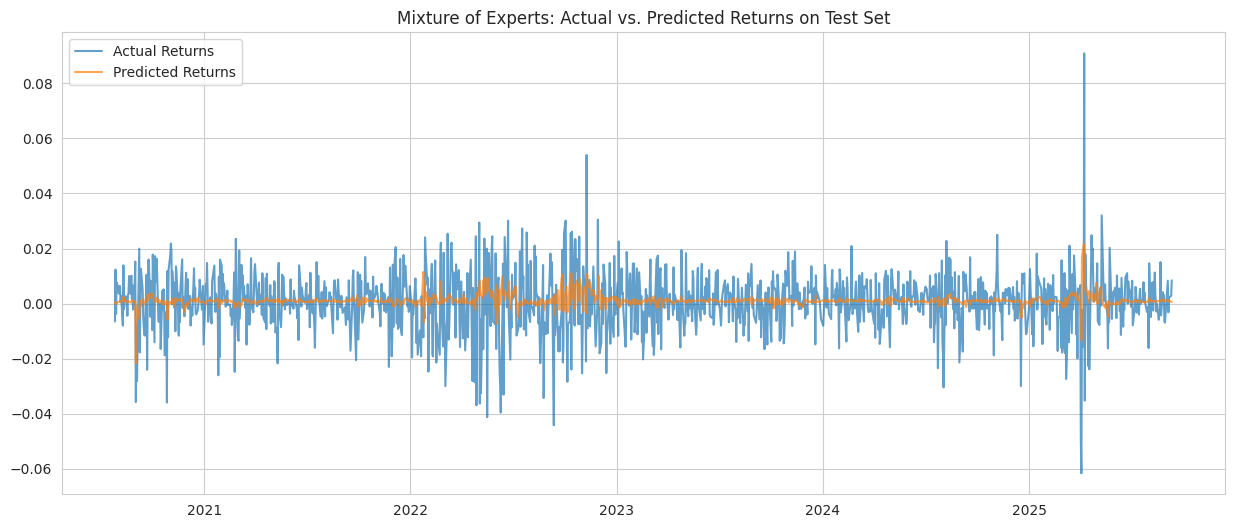

In [11]:
# Set models to evaluation mode
[e.eval() for e in experts]
test_preds = []
test_actuals = []

with torch.no_grad():
    for xb, yb, gb in test_loader:
        expert_outputs = torch.stack([experts[k](xb) for k in range(K)], dim=1)
        y_hat = (gb * expert_outputs).sum(dim=1)
        test_preds.extend(y_hat.numpy())
        test_actuals.extend(yb.numpy())

test_preds = np.array(test_preds)
test_actuals = np.array(test_actuals)

# Calculate final MSE on the test set
test_mse = np.mean((test_preds - test_actuals)**2)
print(f"Final Mean Squared Error on Test Set: {test_mse:.8f}")

# Visualize predictions vs actuals as a time series
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, test_actuals, label='Actual Returns', alpha=0.7)
plt.plot(y_test.index, test_preds, label='Predicted Returns', alpha=0.7)
plt.title('Mixture of Experts: Actual vs. Predicted Returns on Test Set')
plt.legend()
plt.show()

Cell 10: Save the Trained Models

We'll save the state of each expert so we can load them directly in the next notebook for backtesting.

In [12]:
for k in range(K):
    torch.save(experts[k].state_dict(), f'expert_model_regime_{k}.pth')

print("Trained expert models have been saved.")

Trained expert models have been saved.
